# **SENTIMENT ANALYSIS USING bi LSTM**

In [1]:
import pandas as pd
import numpy as np
import re
import string
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS


In [3]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

from nltk.stem import WordNetLemmatizer
from nltk import ngrams

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Embedding, Dropout, Flatten, Layer, Input
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K


In [4]:
df=pd.read_csv('/content/drive/MyDrive/Sentiment analysis/project 2024/sentiment analysis/movie review.csv')
del df['Unnamed: 0']
df.head()

,review,sentiment
0,One reviewer mentioned after watching Oz episo...,positive
1,A wonderful little production The filming tech...,positive
2,I thought wonderful way spend time hot summer ...,positive
3,Basically s family little boy Jake think s zom...,negative
4,Petter Mattei Love Time Money visually stunnin...,positive


In [5]:
def sentiment(text):
  if text=='positive':
    return 1
  else:
    return 0
df['sentiment']=df['sentiment'].apply(sentiment)
df.head()

,review,sentiment
0,One reviewer mentioned after watching Oz episo...,1
1,A wonderful little production The filming tech...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically s family little boy Jake think s zom...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [6]:
df.shape

(50000, 2)

In [7]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [8]:
Xtrain, Xcv, Ytrain, Ycv = train_test_split(df['review'], df['sentiment'], random_state=21, test_size=0.3)


In [9]:
# Tokenize our training data
tokenizer = Tokenizer(num_words=20000, oov_token='<UNK>')
tokenizer.fit_on_texts(Xtrain)

# word to number and vice versa map
word2num = tokenizer.word_index
num2word = {k:w for w, k in word2num.items()}

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(Xtrain)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=100)


test_sequences = tokenizer.texts_to_sequences(Xcv)
test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=100)


# **Initialize model**

In [10]:

class Attention(Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(Attention,self).get_config()

In [11]:
inp = Input(shape=(100, ))
x = Embedding(20000, 256, trainable=False)(inp)
x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.25,recurrent_dropout=0.25))(x)
x = Attention()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 256)          5120000   
                                                                 
 bidirectional (Bidirection  (None, 100, 600)          1336800   
 al)                                                             
                                                                 
 attention (Attention)       (None, 600)               700       
                                                                 
 dense (Dense)               (None, 256)               153856    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
file_path = 'model.hdf5'
ckpt = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=1)

In [14]:
model.fit(train_padded, Ytrain, batch_size=1024, epochs=20,
validation_data=(test_padded, Ycv), callbacks=[ckpt])

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.5889
Epoch 1: val_loss improved from inf to 0.67350, saving model to model.hdf5
35/35 [==============================] - 32s 916ms/step - loss: 0.6822 - accuracy: 0.5889 - val_loss: 0.6735 - val_accuracy: 0.6305
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.6377
Epoch 2: val_loss improved from 0.67350 to 0.65887, saving model to model.hdf5
35/35 [==============================] - 31s 883ms/step - loss: 0.6752 - accuracy: 0.6377 - val_loss: 0.6589 - val_accuracy: 0.6035
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6505
Epoch 3: val_loss improved from 0.65887 to 0.59598, saving model to model.hdf5
35/35 [==============================] - 31s 888ms/step - loss: 0.6341 - accuracy: 0.6505 - val_loss: 0.5960 - val_accuracy: 0.6895
Epoch 4/20
35/35 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.6870
Epoch 4: val_loss improved from 0.59598 to 0.58058, saving model to model.hdf5
35/35 [==============================] - 29s 846ms/step - loss: 0.5888 - accuracy: 0.6870 - val_loss: 0.5806 - val_accuracy: 0.6938
Epoch 5/20
35/35 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.6931
Ep

In [15]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#464646'
#plt.rcParams['axes.edgecolor'] = '#FFFFFF'
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['text.color'] = '#666666'
plt.rcParams['axes.labelcolor'] = '#666666'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.color'] = '#666666'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.color'] = '#666666'
plt.rcParams['ytick.labelsize'] = 14

# plt.rcParams['font.size'] = 16

sns.color_palette('dark')
%matplotlib inline

tqdm.pandas()

469/469 [==============================] - 42s 88ms/step
Accuracy : 0.7401333333333333
f1 score macro : 0.7386342602592333
f1 scoore micro : 0.7401333333333333
Hamming loss : 0.2598666666666667
auc:  0.8219018746845437
Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.67      0.72      7422
           1       0.72      0.81      0.76      7578

    accuracy                           0.74     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.74      0.74      0.74     15000



Text(0.5, 0, 'False Positive Rate')

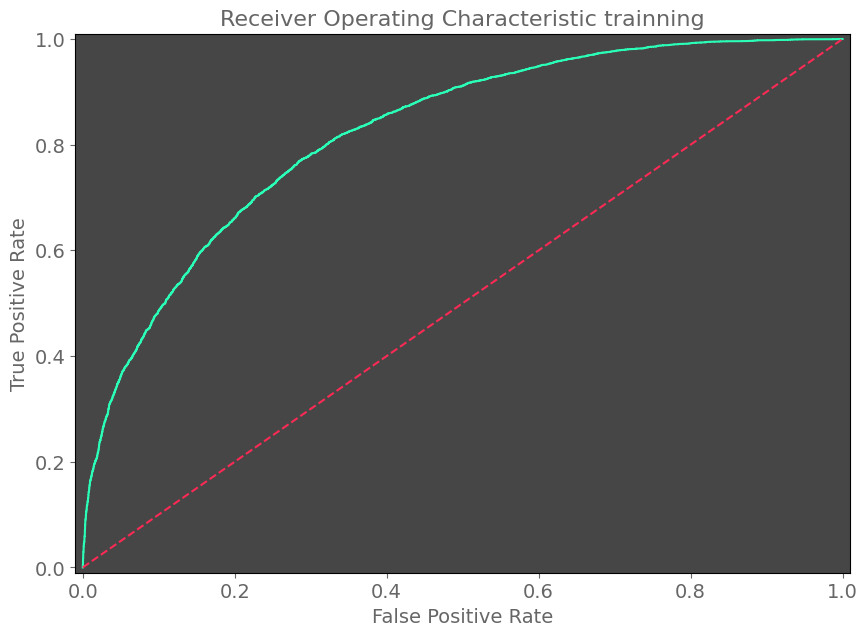

In [16]:
# predict tags
Ycv_pred0 = model.predict(test_padded)
Ycv_pred = (Ycv_pred0 > 0.5).astype('int64')
# print model performance metrics
print("Accuracy :",metrics.accuracy_score(Ycv,Ycv_pred))
print("f1 score macro :",metrics.f1_score(Ycv,Ycv_pred, average = 'macro'))
print("f1 scoore micro :",metrics.f1_score(Ycv,Ycv_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(Ycv,Ycv_pred))
fpr, tpr, thresh = roc_curve(Ycv, Ycv_pred0)
print("auc: ", auc(fpr,tpr))
print("Classification report: \n", metrics.classification_report(Ycv, Ycv_pred))

fig, ax = plt.subplots(figsize=[10,7])
ax.set_title('Receiver Operating Characteristic trainning')
ax.plot(fpr,tpr,sns.xkcd_rgb['greenish cyan'])
ax.plot([0,1],[0,1],ls='--', c=sns.xkcd_rgb['red pink'])
ax.set_xlim([-0.01,1.01])
ax.set_ylim([-0.01,1.01])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
